In [1]:
%matplotlib inline


# Collocating eddies and NPP data

Script will use py-eddy-tracker methods to upload external data (Satellite NPP)
in a common structure with altimetry.

Figures higlights the different steps.


In [2]:
import xarray as xr
from datetime import datetime
# --------------------------------------------------------
# specify the date and lon-lat domain of the analysis here
# --------------------------------------------------------
date = datetime(2016, 6, 1)
extent = [200, 240, 42, 62]

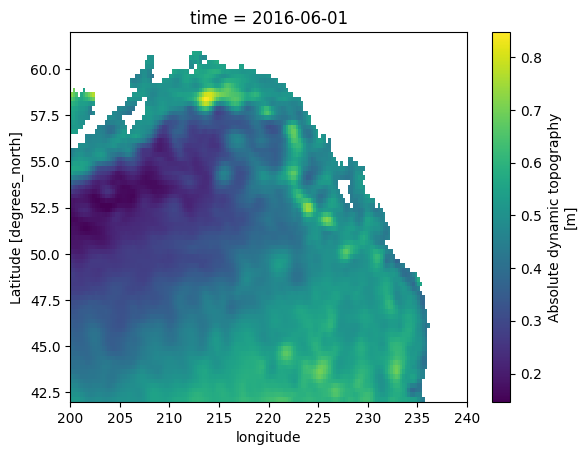

In [3]:
# --------------------------------------------------------
# select date and domain of the altimetry data
# display the analysis domain
# --------------------------------------------------------
ds=xr.open_dataset('~/project36/obs/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2016.nc')
ds1=ds.sel(time=date,method='nearest')
x=ds['longitude']+360
ds1['longitude']=x
ds2=ds1.sel(longitude=slice(extent[0],extent[1])).sel(latitude=slice(extent[2],extent[3]))
ds2.to_netcdf('ssh.nc')
ds2=xr.open_dataset('ssh.nc')
ds2.adt.plot()

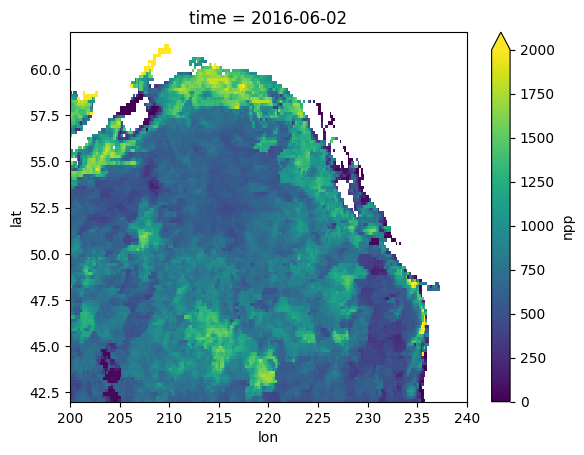

In [4]:
# --------------------------------------------------------
# select date and domain of the NPP data
# display the analysis domain
# --------------------------------------------------------
ds=xr.open_dataset('~/project36/obs/npp_CbPM-MODIS_8day_GOA.nc')
ds1=ds.sel(time=date,method='nearest')
x=ds1['lon'].to_numpy()+360
ds1['lon']=x
ds2=ds1.sel(lon=slice(extent[0],extent[1])).sel(lat=slice(extent[2],extent[3]))
ds2.to_netcdf('npp.nc')
ds2=xr.open_dataset('npp.nc')
ds2.npp.plot(vmin=0,vmax=2000)

In [5]:
# --------------------------------------------------------
# import necessary packages
# --------------------------------------------------------
from matplotlib import pyplot as plt
from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
filename_alt = "ssh.nc"
filename_npp = "npp.nc"
var_name_npp = "npp"

## Loading data



In [6]:
# --------------------------------------------------------
# read in the data using 'RegularGridDataset' 
# --------------------------------------------------------
npp = RegularGridDataset(filename=filename_npp, x_name="lon", y_name="lat", nan_masking=True,)
alti = RegularGridDataset(filename=filename_alt, x_name="longitude", y_name="latitude", nan_masking=True,)
# --------------------------------------------------------
# We can use `Grid` tools, 'regrid' method to interpolate ADT on the sst grid
# This step combines altimetry data into NPP gridded dataset
# --------------------------------------------------------
npp.regrid(alti, "adt")
# This step calculate geostrophic circulation based on altimetry data
npp.add_uv("adt")

We assume pixel position of grid is centered for npp.nc
We assume pixel position of grid is centered for ssh.nc


Functions to initiate figure axes



In [7]:
# ---------------------------------------------------------------
# these are helper functions for setting up the plot efficiently
# ---------------------------------------------------------------
def start_axes(title, extent=extent):
    fig = plt.figure(figsize=(13, 6), dpi=120)
    ax = fig.add_axes([0.03, 0.05, 0.89, 0.91])
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_title(title)
    ax.set_aspect("equal")
    return ax
def update_axes(ax, mappable=None, unit=""):
    ax.grid()
    if mappable:
        cax = ax.figure.add_axes([0.93, 0.05, 0.01, 0.9], title=unit)
        plt.colorbar(mappable, cax=cax)

## ADT = absolute dynamic topography, display
    - Use the helper functions

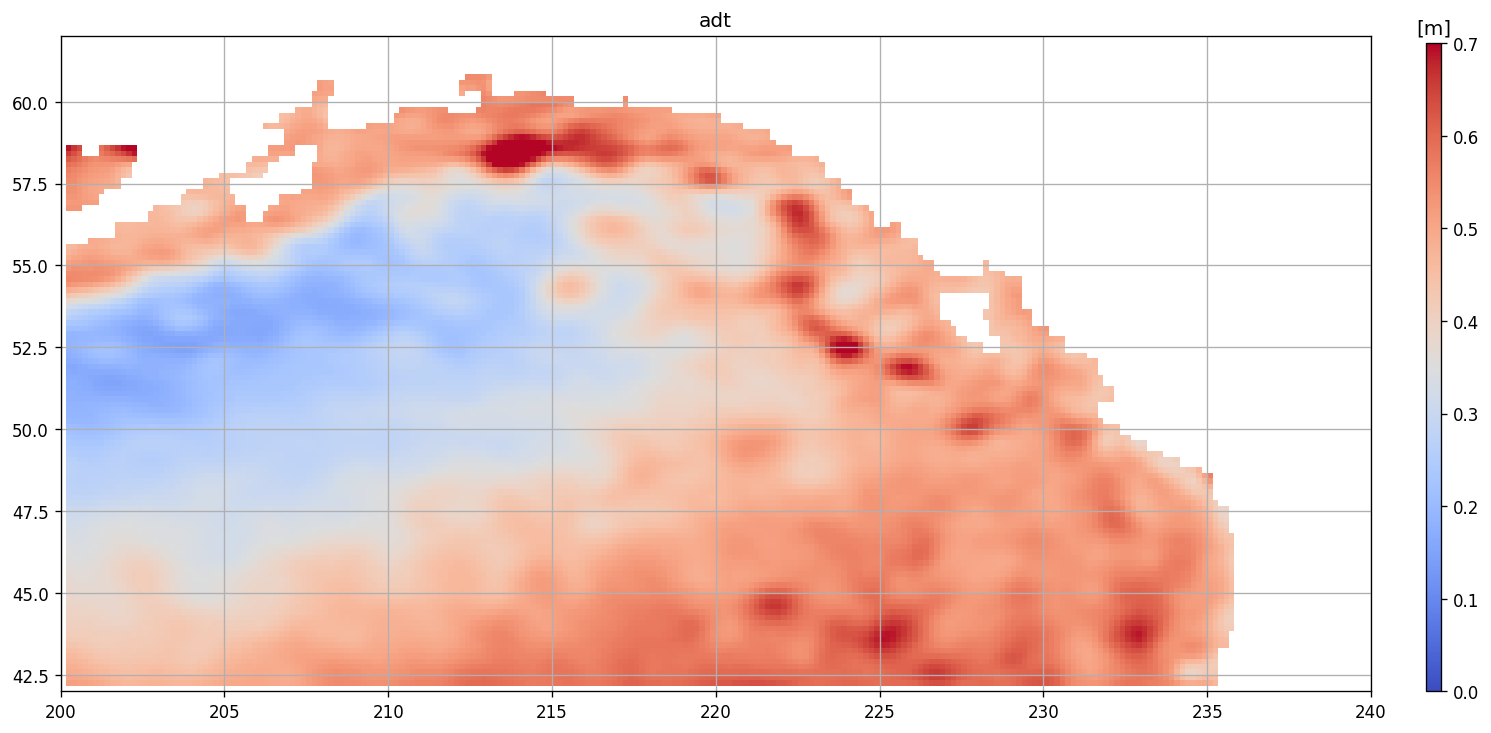

In [8]:
ax = start_axes("adt", extent=extent)
m = npp.display(ax, "adt", vmin=0, vmax=.7)
update_axes(ax, m, unit="[m]")

## NPP display



We can now plot NPP from `npp`



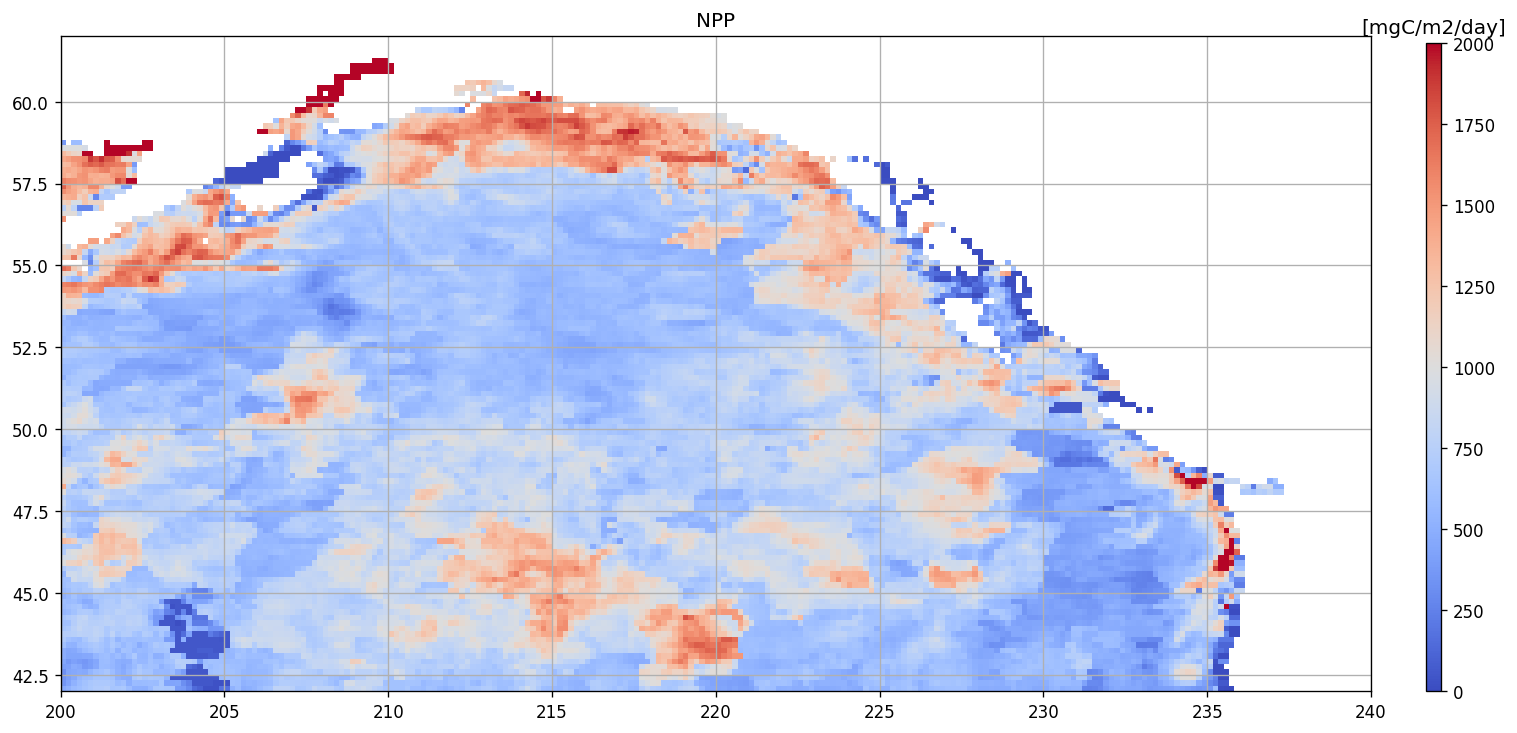

In [9]:
ax = start_axes("NPP")
m = npp.display(ax, "npp", vmin=0, vmax=2000)
update_axes(ax, m, unit="[mgC/m2/day]")

### Overlay the circulation field (calculated from ADT) on top of the NPP field

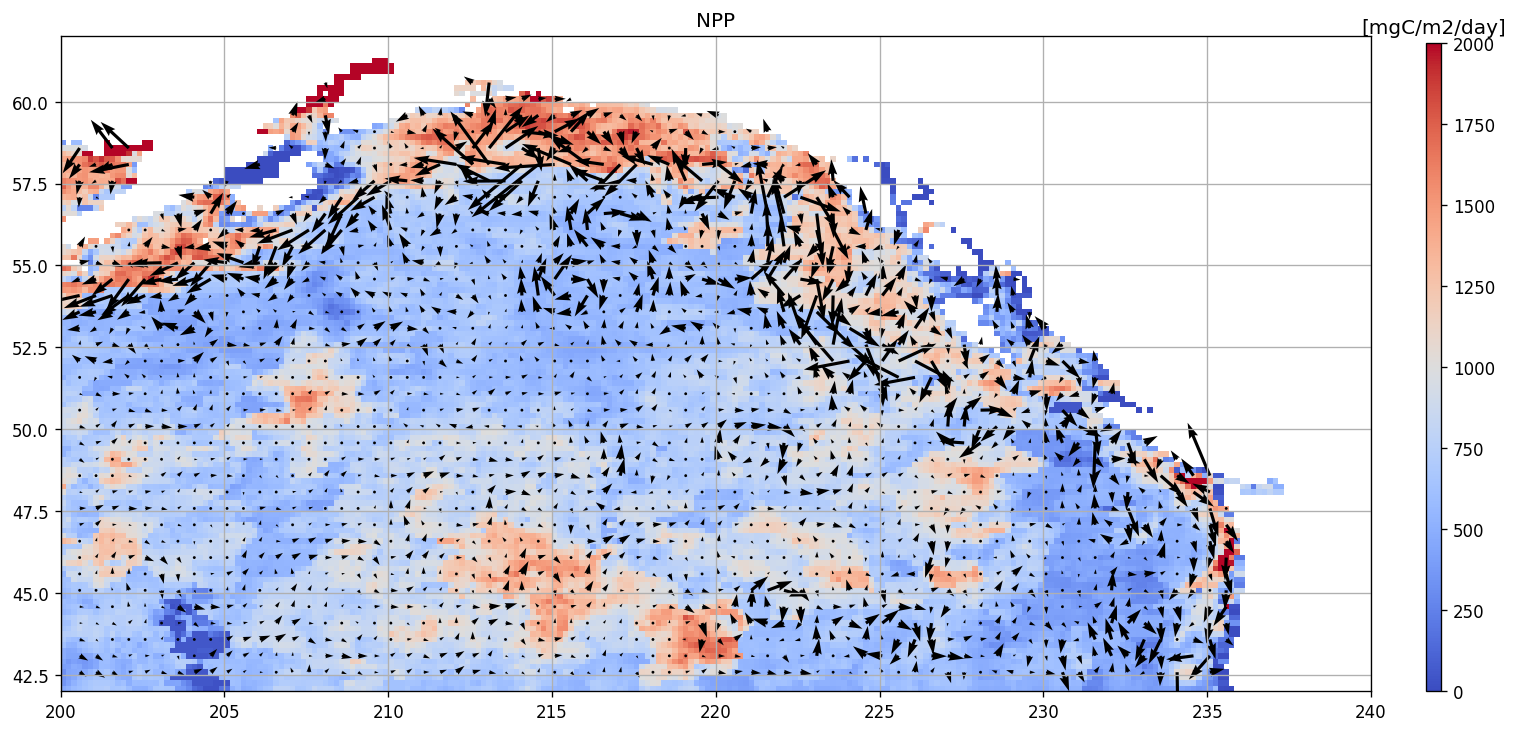

In [10]:
st = 3
ax = start_axes("NPP")
m = npp.display(ax, "npp", vmin=0, vmax=2000)
u, v = npp.grid("u").T, npp.grid("v").T
ax.quiver(npp.x_c[::st], npp.y_c[::st], u[::st, ::st], v[::st, ::st], scale=10)
update_axes(ax, m, unit="[mgC/m2/day]")

Now, with eddy contours, and displaying SST anomaly



In [11]:
# ------------------------------------------------------------
# Apply spatial filter to select for the small scale features
# number is in the units of km
# ------------------------------------------------------------
npp.bessel_high_filter("npp", 400)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


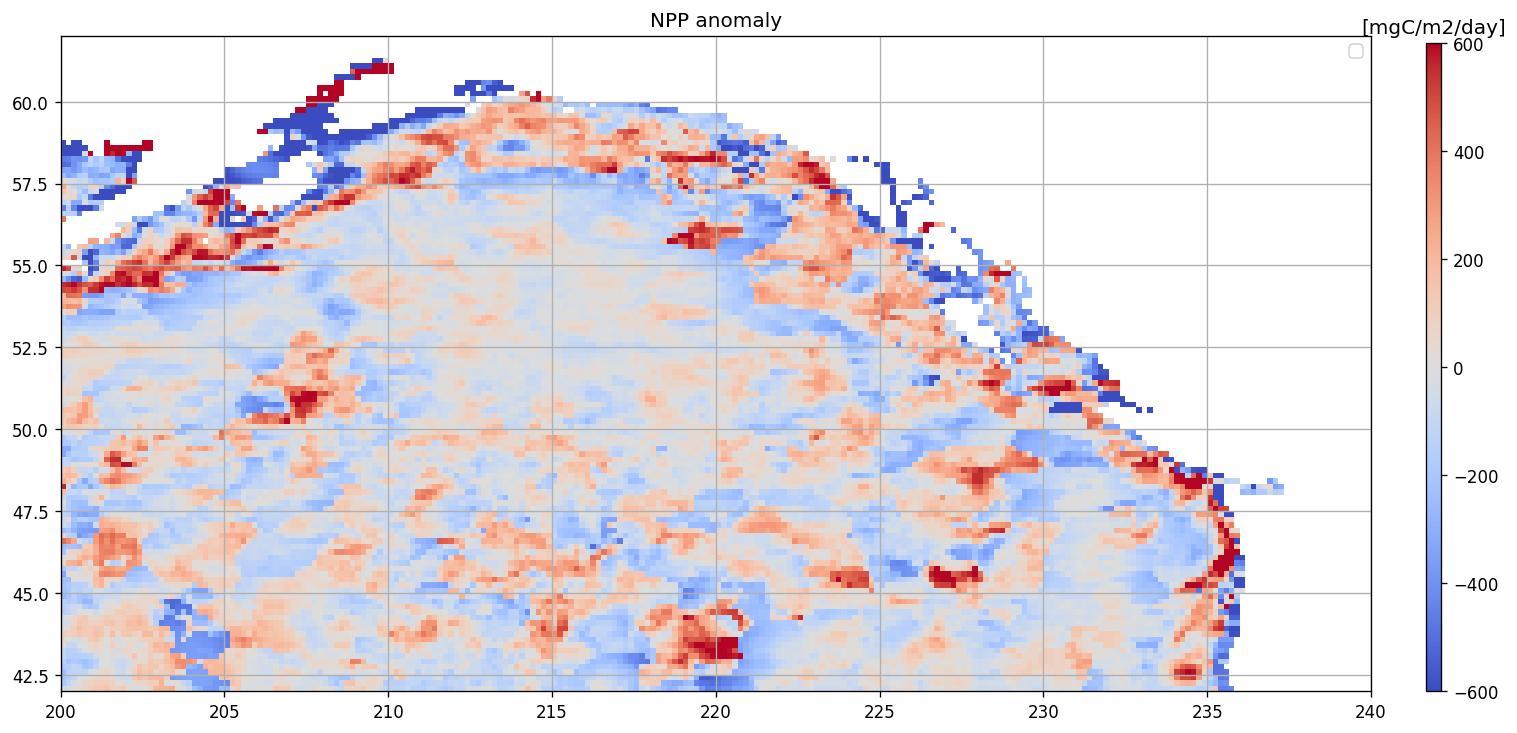

In [12]:
ax = start_axes("NPP anomaly")
m = npp.display(ax, "npp", vmin=-600, vmax=600)
#m = npp.display(ax, "npp", vmin=0, vmax=2000)
ax.legend()
#ax.quiver(npp.x_c[::st], npp.y_c[::st], u[::st, ::st], v[::st, ::st], scale=10)
update_axes(ax, m, unit="[mgC/m2/day]")

## Eddy detection



In [13]:
npp.bessel_high_filter("adt", 400)

/glade/work/ito/miniconda3/envs/REU-2023b/lib/python3.10/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


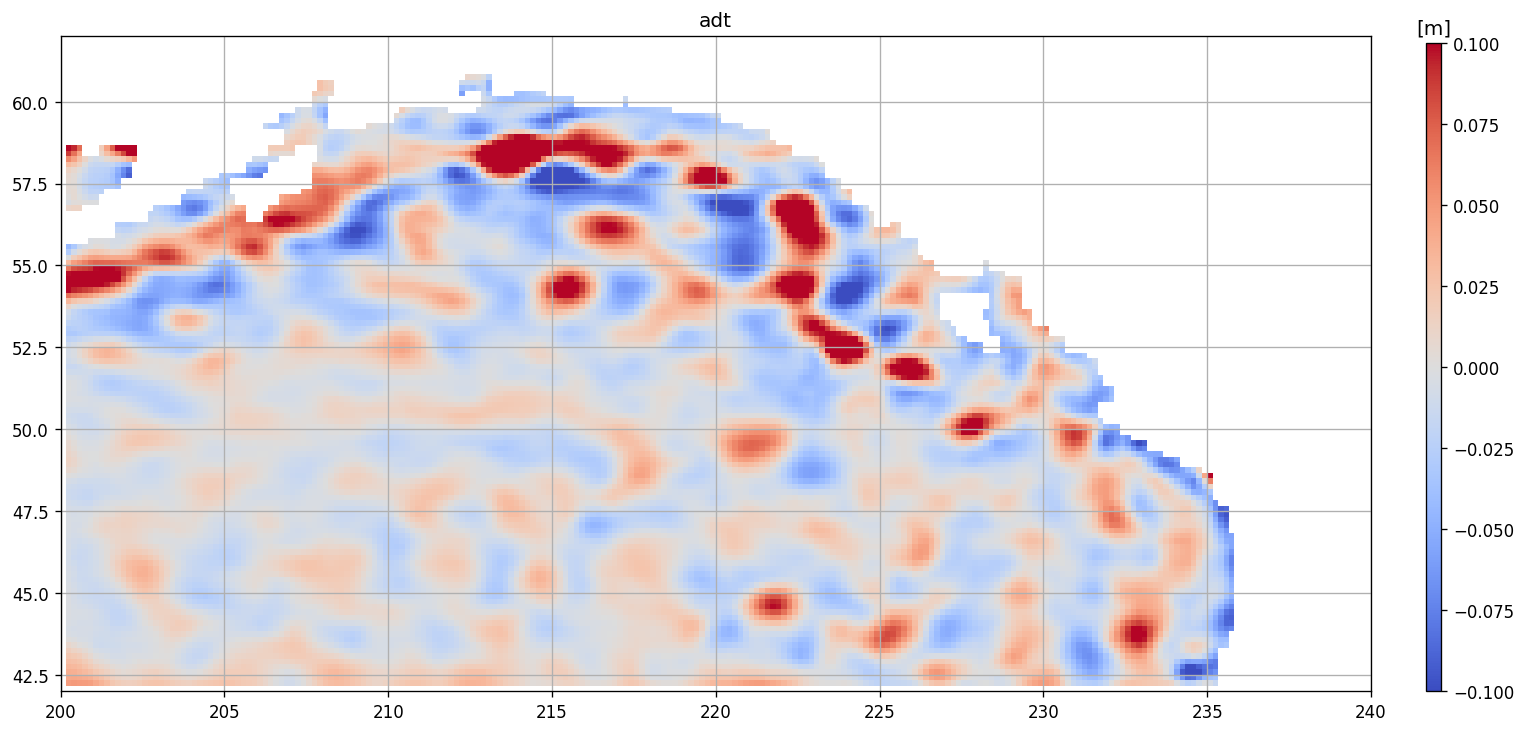

In [14]:
# ADT filtered
ax = start_axes("adt", extent=extent)
m = npp.display(ax, "adt", vmin=-0.1, vmax=0.1)
update_axes(ax, m, unit="[m]")
# -----------------------------------------------------------
# The eddy detection takes ssh, u, v velocities as input
#  additional input is date and step between two layers
# -----------------------------------------------------------
a, c = npp.eddy_identification("adt", "u", "v", date, 0.005)

In [15]:
kwargs_a = dict(lw=2, label="Anticyclonic", ref=-10, color="b")
kwargs_c = dict(lw=2, label="Cyclonic", ref=-10, color="r")

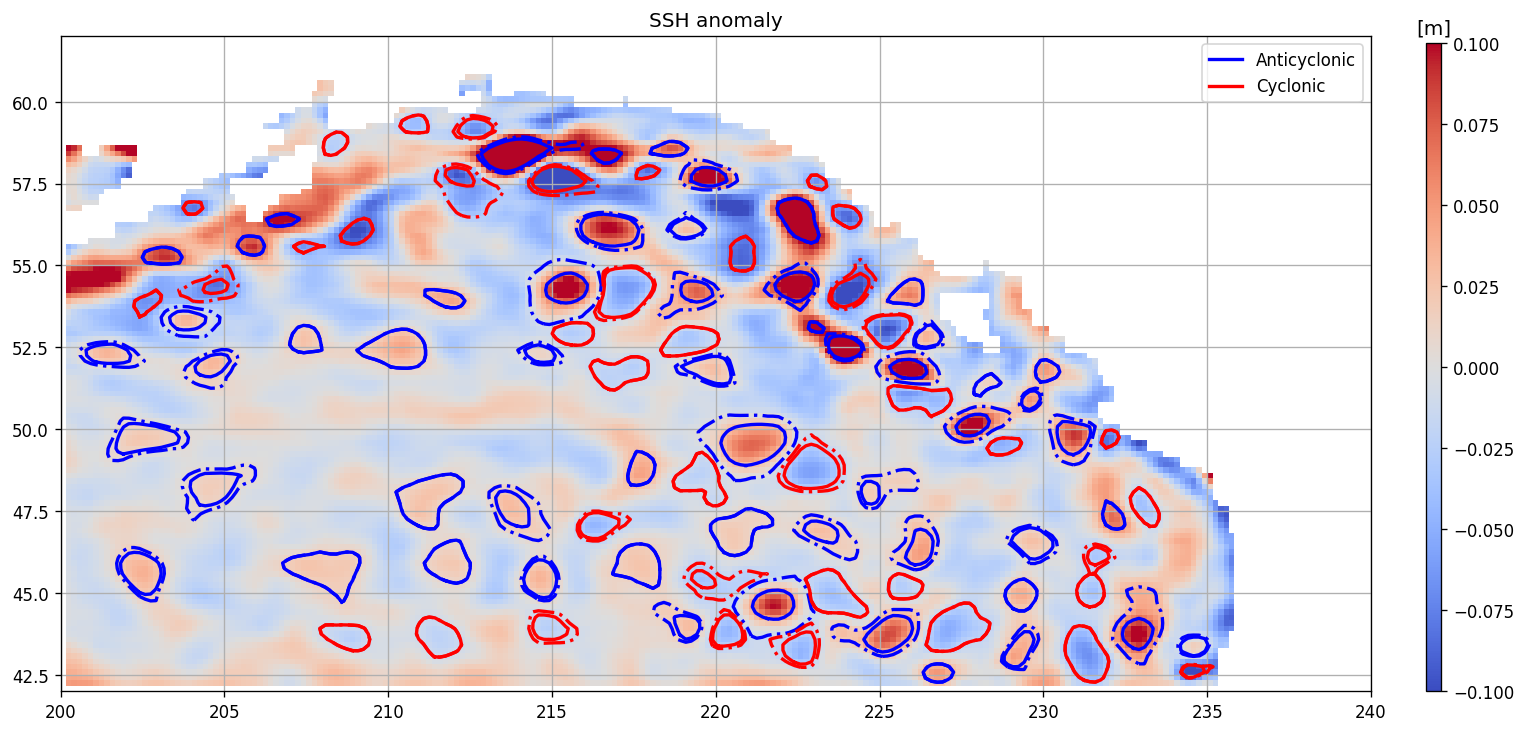

In [16]:
ax = start_axes("SSH anomaly")
m = npp.display(ax, "adt", vmin=-.1, vmax=.1)
a.display(ax, **kwargs_a), c.display(ax, **kwargs_c)
ax.legend()
update_axes(ax, m, unit="[m]")

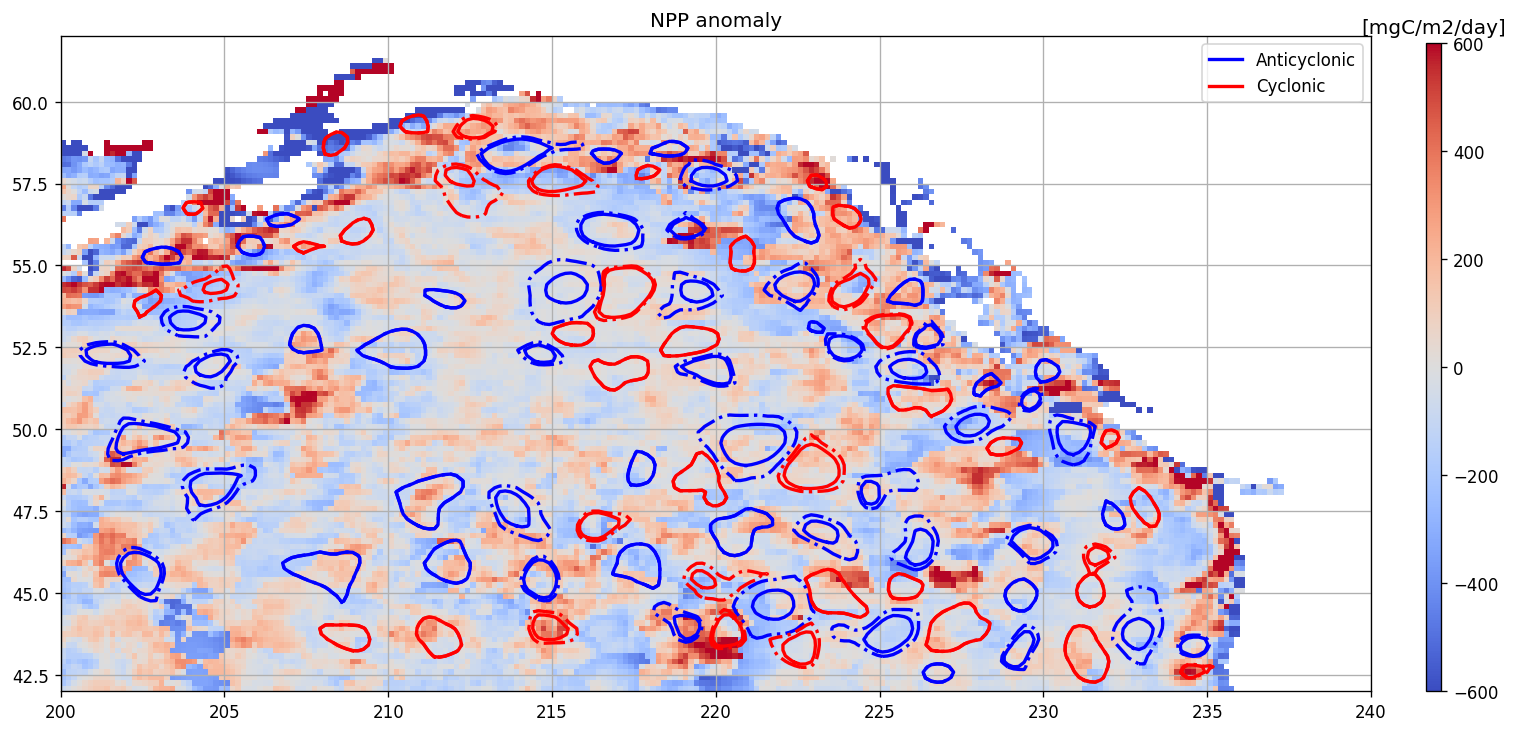

In [17]:
ax = start_axes("NPP anomaly")
m = npp.display(ax, "npp", vmin=-600, vmax=600)
#m = npp.display(ax, "npp", vmin=0, vmax=2000)
a.display(ax, **kwargs_a), c.display(ax, **kwargs_c)
ax.legend()
update_axes(ax, m, unit="[mgC/m2/day]")

## Example of post-processing
Get mean of npp anomaly_high in each internal contour



In [18]:
anom_a = a.interp_grid(npp, "npp", method="mean", intern=True)
anom_c = c.interp_grid(npp, "npp", method="mean", intern=True)

Are cyclonic (resp. anticyclonic) eddies generally associated with positive (resp. negative) NPP anomaly ?



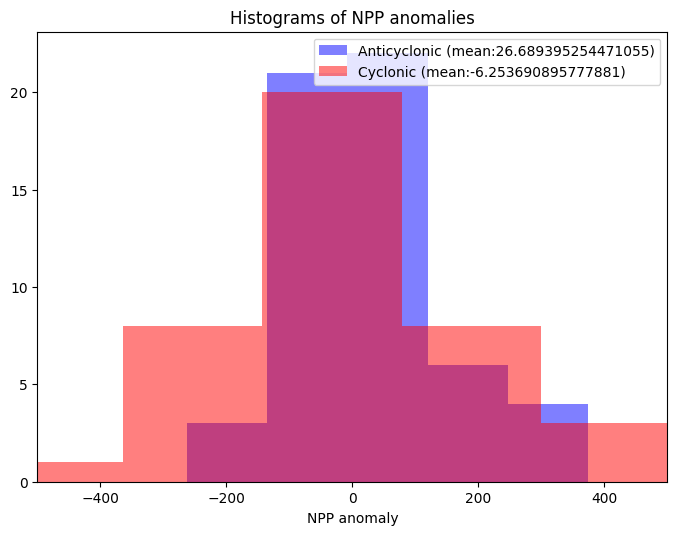

In [19]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0.05, 0.05, 0.90, 0.90])
ax.set_xlabel("NPP anomaly")
#ax.set_xlim([0, 2000])
ax.set_xlim([-500, 500])
ax.set_title("Histograms of NPP anomalies")
ax.hist(
    anom_a, 5, alpha=.5, color="b", label="Anticyclonic (mean:%s)" % (anom_a.mean())
)
ax.hist(anom_c, 5, alpha=.5, color="r", label="Cyclonic (mean:%s)" % (anom_c.mean()))
ax.legend()

In [20]:
import numpy
numpy.version.version

'1.24.3'

In [21]:
import netCDF4 
netCDF4.getlibversion()

'4.9.1 of Mar  2 2023 00:43:32 $'

In [22]:
import numpy as np
np.version.version

'1.24.3'